<a href="https://colab.research.google.com/github/bominwang/Bayesian-statistics-method/blob/Bayesian-model-calibration/BC_MCMC_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
import sys
import os
from google.colab import drive
drive.mount('/content/drive')
# 这里一定要加绝对绝对路径os.path.abspath
path = '/content/drive/MyDrive/Colab Notebooks/bm_wang/Bayesian_statistics_method/bayesian_model_averaging'
sys.path.append(os.path.abspath(path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [98]:
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
from scipy import stats
import seaborn

In [99]:
!pip install -U emcee
import emcee

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


定义试验数据

In [100]:
ins_exp = np.array([1,7,14,21,28,90,180,270,360]).reshape(-1,1)
lab_exp = np.array([0.259,0.544,0.639,0.727,0.796,1.054,1.189,1.297,1.410]).reshape(-1,1)

导入待验证模型

In [101]:
from bma_demo import Mathematical_examples_1

原始参数空间下模型预测

In [102]:
def displot_originalspace():
  x = np.linspace(1, 360, 1000).reshape(1000)
  # model1
  mu_y1 = []
  std_y1 = []
  for i in range(x.shape[0]):
    ins = x[i]
    theta1 = np.random.uniform(low = 1.924 - 0.1 * 1.925, high = 1.924 * 0.1 + 1.924, size = [1000,1])
    theta2 = np.random.uniform(low = 0.6 - 0.1 * 0.6, high = 0.6 * 0.1 + 0.6, size = [1000,1])
    input = np.concatenate((np.concatenate((ins * np.ones([1000,1]), theta1), axis = 1), theta2), axis = 1)
    y1 = Mathematical_examples_1.func_1(input)
    mu = np.mean(y1, axis = 0)
    std = np.std(y1, axis = 0)
    mu_y1.append(mu)
    std_y1.append(std)
  my_y1 = np.array(mu_y1)
  std_y1 = np.array(std_y1)
  plt.figure(1, figsize=(10, 8), dpi=80)
  plt.scatter(ins_exp, lab_exp)
  plt.plot(x, mu_y1, '-c', label = 'model1')
  plt.fill_between(x, mu_y1 - 3 * std_y1, mu_y1 + 3 * std_y1, alpha=0.4, color='c');
  plt.title('the prediction of model 1 under the original paramter space')
  plt.legend()
  plt.show()

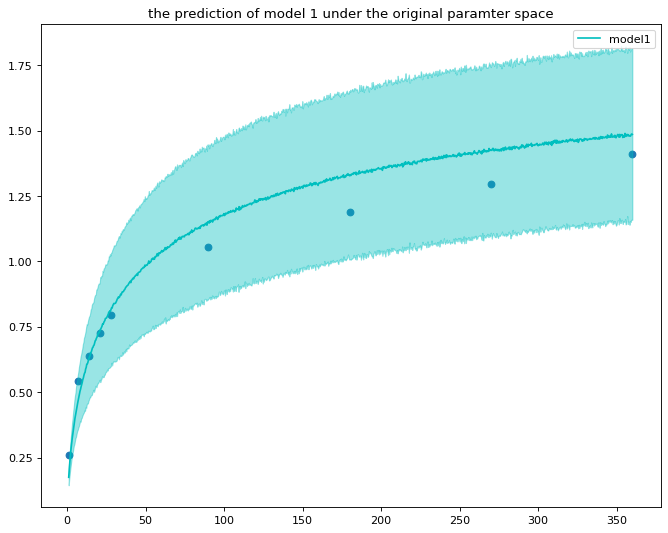

In [103]:
displot_originalspace()

基于PYMC3的变分贝叶斯模型修正

假设预测数据和试验数据间的差异服从如下概率模型：

y_exp = y_model + epsilon

epsilon为零均值高斯分布，其方差通过最大似然估计求解

epsilon~N(O, sigma^2)

sigma = sum(power(y_exp - y_model, 2)) / N



In [104]:
class log_posterior(object):
  def __init__(self, ins_exp, out_exp, model):
    self.ins_exp = ins_exp.reshape(-1,1)
    self.lab_exp = lab_exp.reshape(-1,1)
    self.model = model
  
  def log_piror(self, theta):
    theta1, theta2 = theta
    if 1.924 - 0.1 * 1.925 < theta1 <1.924 + 0.1 * 1.925 and 0.6 - 0.1 * 0.6 < theta2 < 0.6 + 0.1 * 0.6 :
      return 0.0
    return -np.inf
  
  def sigma_c(self, theta):
    theta1, theta2 = theta
    theta1 = np.repeat(theta1, self.ins_exp.shape[0], axis = 0).reshape(-1, 1)
    theta2 = np.repeat(theta2, self.ins_exp.shape[0], axis = 0).reshape(-1, 1)
    input = np.concatenate([self.ins_exp, theta1, theta2], axis = 1)
    pred = self.model(input)
    sigma2 = np.mean(np.power(pred.reshape(-1, 1) - self.lab_exp, 2))
    return sigma2
  
  def log_likelihood(self, theta):
    theta1, theta2 = theta
    sigma2 = self.sigma_c(theta)
    log_lik = np.log(np.power(2 * np.pi * sigma2, - 0.5 * self.ins_exp.shape[0])) - 0.5 * self.ins_exp.shape[0]
    return log_lik
  
  def log_posterior(self, theta):
    lp = self.log_piror(theta)
    if not np.isfinite(lp):
      return -np.inf
    ll = self.log_likelihood(theta)
    return ll + lp

In [105]:
ndim = 2
nwalkers = 500
pos = np.random.rand(nwalkers, ndim) * np.array([[0.1, 0.1]]) + np.array([[1.9, 0.6]])
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior(ins_exp, lab_exp, Mathematical_examples_1.func_1).log_posterior)
sampler.run_mcmc(pos, 5000, progress=True)

  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [02:43<00:00, 30.57it/s]


State([[1.95304968 0.57094935]
 [1.86608985 0.57573789]
 [1.87429952 0.58760869]
 [1.81143208 0.58934252]
 [1.98614604 0.54710791]
 [2.03608306 0.54010586]
 [1.75096545 0.62850499]
 [1.99811059 0.54320865]
 [1.97314483 0.54591551]
 [1.73325943 0.62464946]
 [1.7812977  0.6188911 ]
 [1.92952077 0.55336468]
 [1.86435106 0.56368907]
 [1.90810704 0.54735405]
 [1.84989961 0.56519819]
 [1.93303221 0.5636813 ]
 [1.75873018 0.6003452 ]
 [2.04171651 0.54498153]
 [1.74171661 0.63313758]
 [1.76782428 0.60234142]
 [2.04308843 0.54697823]
 [1.90736746 0.57639218]
 [1.77471306 0.60201797]
 [1.85252501 0.55811682]
 [1.87891886 0.56684001]
 [1.86179016 0.55764701]
 [1.78507786 0.59832049]
 [1.88597507 0.59123525]
 [2.00443786 0.56400523]
 [1.9464924  0.54972259]
 [1.96027994 0.54345971]
 [2.01698349 0.55328451]
 [1.85248493 0.57550011]
 [1.77081221 0.60269636]
 [1.79126815 0.6307619 ]
 [1.85218999 0.58167977]
 [1.76695447 0.62457496]
 [1.96517352 0.55713864]
 [1.82286183 0.60435343]
 [2.00649389 0.5479

[1.87462753 0.58028771]
[0.08485229 0.02739768]


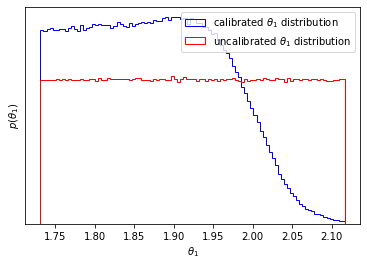

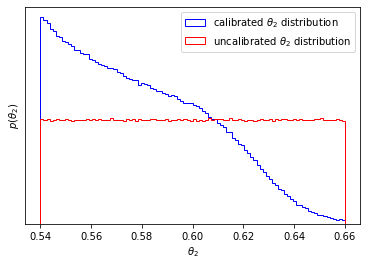

In [106]:
samples = sampler.get_chain(flat=True)
print(np.mean(samples, axis=0))
print(np.std(samples, axis=0))
samples = sampler.get_chain(flat=True)
plt.figure(1)
original_theta1 = np.random.uniform(low = 1.924 - 0.1 * 1.925, high = 1.924 * 0.1 + 1.924, size = [samples[20000:,0].shape[0]])
plt.hist(samples[20000:, 0], 100, color="b", histtype="step", label = r'calibrated $\theta_1$ distribution')
plt.hist(original_theta1, 100, color="r", histtype="step", label = r'uncalibrated $\theta_1$ distribution')
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.legend(loc = 1)
plt.gca().set_yticks([]);
plt.figure(2)
original_theta1 = np.random.uniform(low = 0.6 - 0.1 * 0.6, high = 0.6 + 0.1 * 0.6, size = [samples[20000:,0].shape[0]])
plt.hist(samples[20000:, 1], 100, color="b", histtype="step", label = r'calibrated $\theta_2$ distribution')
plt.hist(original_theta1, 100, color="r", histtype="step", label = r'uncalibrated $\theta_2$ distribution')
plt.xlabel(r"$\theta_2$")
plt.ylabel(r"$p(\theta_2)$")
plt.legend(loc = 1)
plt.gca().set_yticks([]);

In [107]:
def displot_calibrated_space(theta):
  x = np.linspace(1, 360, 1000).reshape(1000)
  # model1
  mu_y1 = []
  std_y1 = []
  for i in range(x.shape[0]):
    ins = x[i]
    theta1 = theta[:,0]
    theta2 = theta[:,1]
    input = np.concatenate((ins * np.ones([theta.shape[0],1]), theta1.reshape(-1,1), theta2.reshape(-1,1)), axis = 1)
    y1 = Mathematical_examples_1.func_1(input)
    mu = np.mean(y1, axis = 0)
    std = np.std(y1, axis = 0)
    mu_y1.append(mu)
    std_y1.append(std)
  my_y1 = np.array(mu_y1)
  std_y1 = np.array(std_y1)
  plt.figure(1, figsize=(10, 8), dpi=80)
  plt.scatter(ins_exp, lab_exp)
  plt.plot(x, mu_y1, '-c', label = 'model1')
  plt.fill_between(x, mu_y1 - 3 * std_y1, mu_y1 + 3 * std_y1, alpha=0.4, color='c');
  plt.title('the prediction of model 1 under the original paramter space')
  plt.legend()
  plt.show()

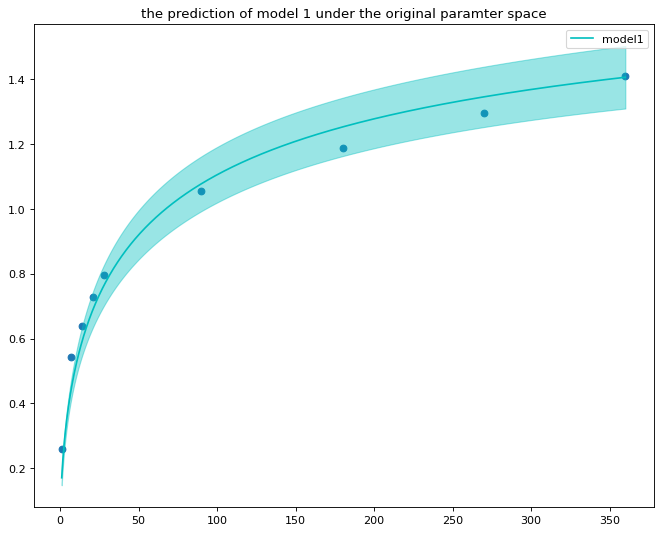

In [108]:
displot_calibrated_space(samples[20000:,:])